In [1]:
import json
from ase import Atoms, Atom
from ase.visualize import view
from ase.constraints import dict2constraint
from ase.calculators.singlepoint import SinglePointCalculator
from pymatgen.io.ase import AseAtomsAdaptor

from pymatgen.analysis.local_env import CrystalNN
from pymatgen.core.structure import IStructure
from pymatgen.core.periodic_table import Element
from mp_api.client import MPRester


from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import (Miedema, WenAlloys,BandCenter,)

import pandas as pd
import numpy as np

from tqdm import tqdm
import time

import warnings
warnings.filterwarnings("ignore")

import scipy.io as sio
import numpy.matlib as nm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

import sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
import scipy

from sklearn.metrics.pairwise import pairwise_distances

C:\Users\hlk19\anaconda3\lib\site-packages\pymatgen\analysis\phase_diagram.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Initial Dataset

In [2]:
df = pd.read_json('h_data.json').dropna()
print('# of adsorption site:', len(df))
print("type of intermetallic materials:",len(df['mpid'].unique()))
df.head(5)

# of adsorption site: 22675
type of intermetallic materials: 995


,adsorbate,mpid,miller,shift,top,coordination,neighborcoord,energy,atoms,results,initial_configuration
0,H,mp-632250,"[1, 1, 0]",0.000000,True,H,[H:H-H],-3.320858,"{'atoms': [{'symbol': 'H', 'position': [1.7595...","{'energy': -7.11874891, 'forces': [[-9e-08, -1...","{'atoms': {'atoms': [{'symbol': 'H', 'position..."
1,H,mp-865082,"[1, 0, 0]",0.125000,False,Ca-Na,"[Ca:Au-Au-Au-Au-Na-Na-Na, Na:Au-Au-Au-Au-Ca-Ca...",0.017842,"{'atoms': [{'symbol': 'H', 'position': [3.8027...","{'energy': -22.29980084, 'forces': [[0.0128185...","{'atoms': {'atoms': [{'symbol': 'H', 'position..."
2,H,mp-7956,"[0, 0, 1]",0.166299,False,Na-Sb,"[Na:Na-Na-Na-Sb-Sb, Sb:Na-Na-Na-Na-Na-Na]",-0.172016,"{'atoms': [{'symbol': 'H', 'position': [-2.472...","{'energy': -20.0745408, 'forces': [[-0.0062643...","{'atoms': {'atoms': [{'symbol': 'H', 'position..."
3,H,mp-7956,"[0, 0, 1]",0.166299,False,Sb,[Sb:Na-Na-Na-Na-Na-Na-Na],-0.140213,"{'atoms': [{'symbol': 'H', 'position': [2.7181...","{'energy': -20.04273818, 'forces': [[-0.001605...","{'atoms': {'atoms': [{'symbol': 'H', 'position..."
4,H,mp-865729,"[1, 0, 0]",0.125000,True,Ag,[Ag:Ca-Ca-Sn-Sn],0.870511,"{'atoms': [{'symbol': 'H', 'position': [1.4285...","{'energy': -22.73704972, 'forces': [[-0.000118...","{'atoms': {'atoms': [{'symbol': 'H', 'position..."


# Cleaning & Featurization 

##### Due to the complexity of my dataset the full cleaning & featurization process are not presented in this notebook, and decribed as follow:
(for illustration of a single datapoint, see: https://github.com/ulissigroup/GASpy_manuscript/blob/master/read_data.ipynb)  

##### Cleaning process:
- drop nah & duplicated data
- remove datapoints containing contained the elements on the exclusion list, whose energys value are probably inaccurate, according to the github page of dataset source: https://github.com/ulissigroup/GASpy_manuscript/blob/master/figures/misc_info.ipynb
- remove datapoints with unrecognized material project id

##### Featurization:
Composition featurizer: 
- generate chemical formula based on the mp-id
- apply StrToComposition from matminer to obtain the composition column for the datapoint
- apply the Miedema and WenAlloys from matminer.featurizers.composition.alloy module to obtain features for the intermetallic bulk material
- apply the BandCenter from matminer.featurizers.composition.element module to give a estimate for the band center which is asscociated with the available energy states for the adsorption site 

Structural featurizer:
- convert the structual information from initial dataset to pymatgen structure through the data reading function(from the github page of the dataset) and the AseAtomsAdaptor from pymatgen https://github.com/ulissigroup/GASpy_manuscript/blob/master/read_data.ipynb 
- Apply get_all_neighbors to obtain 8 nearest neighbor for the adsorbate atom (H), and append the atomic number, element electronegativity, and coordination number(using pymatgen.analysis.local_env.CrystalNN) for each neighbor. The feature are divided by the distance between the neigbor and the adsorbate

##### Final cleaning
- remove the datapoint with NaN feature values(Mostly non-intermetallic materials such as SiN,N2,etc.)
- drop the non-digital features
- sort the dataset according to mp-id
- the finalized dataset is saved to "cleaned_H_data.csv" 
 
for detailed cleaning process, see notebook: Data_Cleaning_Featurization.ipynb


### Cleaned Dataset

In [3]:
cdf = pd.read_csv('cleaned_H_data.csv').drop(columns=['Unnamed: 0'])
print('# of adsorption site:', len(cdf))
print("type of intermetallic materials:",len(cdf['mpid'].unique()))
cdf.head(5)

# of adsorption site: 18082
type of intermetallic materials: 746


,mpid,formula,energy,shift,top,miller1,miller2,miller3,Miedema_deltaH_inter,Miedema_deltaH_amor,...,N5_CN,N6_Z,N6_X,N6_CN,N7_Z,N7_X,N7_CN,N8_Z,N8_X,N8_CN
0,mp-10010,Al(CoSi)2,-0.124481,0.913035,1.0,2,2,1,-0.371987,-0.237271,...,3.119071,5.067373,0.352839,1.501444,2.157972,0.267256,0.995987,4.507944,0.611792,2.897964
1,mp-10010,Al(CoSi)2,-0.218654,0.046290,1.0,1,1,1,-0.371987,-0.237271,...,2.166263,3.542187,0.480725,2.783147,4.181096,0.567434,2.090548,3.744218,0.508144,2.139553
2,mp-10010,Al(CoSi)2,-0.312975,0.250000,1.0,1,1,1,-0.371987,-0.237271,...,3.328102,5.004016,0.679116,3.931727,4.884237,0.662861,3.488740,11.232346,0.782104,3.328102
3,mp-10010,Al(CoSi)2,0.143173,0.081350,0.0,0,0,1,-0.371987,-0.237271,...,1.171753,2.728284,0.370267,2.143651,4.119306,0.559049,1.176945,6.413007,0.446535,0.950075
4,mp-10010,Al(CoSi)2,-0.326627,0.913035,1.0,2,2,1,-0.371987,-0.237271,...,2.281525,6.620929,0.461013,1.961757,7.759128,0.540265,1.724251,2.514348,0.341233,1.975559


# Structured Exploration

In [4]:
# create a dictionary for mp-id and the corresponding list of elements of the material 
mp_list = list(df['mpid'].unique())
prop = ['material_id','chemsys']
formu_elem = {}
with MPRester("JcjACBt45HOv4RNHua4YOSrdWEFqoIJw") as mpr:
    docs = mpr.summary.search(material_ids=mp_list,fields=prop)
    formu_elem['mp_id']=[str(getattr(doc, 'material_id')) for doc in docs]
    formu_elem['chemsys']= [getattr(doc,'chemsys').split('-') for doc in docs]
formu_elem = pd.DataFrame.from_dict(formu_elem) 
dic = dict(zip(formu_elem.mp_id, formu_elem.chemsys))

# create a new column of chemical symbols
df['chemsys']=df['mpid'].map(dic)
cdf['chemsys']=cdf['mpid'].map(dic)

# reorder the column for later operation
col_old = list(cdf.keys())
col_new = ['mpid', 'formula','chemsys','energy', 'shift', 'top', 'miller1', 'miller2', 'miller3', 'Miedema_deltaH_inter', 'Miedema_deltaH_amor', 'Miedema_deltaH_ss_min', 'Yang delta', 'Yang omega', 'APE mean', 'Radii local mismatch', 'Radii gamma', 'Configuration entropy', 'Atomic weight mean', 'Total weight', 'Lambda entropy', 'Electronegativity delta', 'Electronegativity local mismatch', 'VEC mean', 'Mixing enthalpy', 'Mean cohesive energy', 'Interant electrons', 'Interant s electrons', 'Interant p electrons', 'Interant d electrons', 'Interant f electrons', 'Shear modulus mean', 'Shear modulus delta', 'Shear modulus local mismatch', 'Shear modulus strength model', 'band center', 'N1_Z', 'N1_X', 'N1_CN', 'N2_Z', 'N2_X', 'N2_CN', 'N3_Z', 'N3_X', 'N3_CN', 'N4_Z', 'N4_X', 'N4_CN', 'N5_Z', 'N5_X', 'N5_CN', 'N6_Z', 'N6_X', 'N6_CN', 'N7_Z', 'N7_X', 'N7_CN', 'N8_Z', 'N8_X', 'N8_CN']
print(set(col_new)==set(col_old))
cdf=cdf[col_new]


Retrieving SummaryDoc documents:   0%|          | 0/973 [00:00<?, ?it/s]

True


The distribution of adsorption sites per bulk strucutures, element presented and adsorption energy(target) are visualized below.

- **MP distribution:** For most intermetallic materials, several to 50 different sites are studies. while several materials have over 200 sites
- **Histogram of element presented:** Mostly metallic elements, both Al and Pt presented in over 3000 adsorption sites of the dataset.
- **Distribution of adsorption energy:** For most of the data, the adsorption energy are within the range of -1 to 1 eV. The interval of 0.1 eV around the ideal adsorption energy -0.27eV are capped by the vertical lines

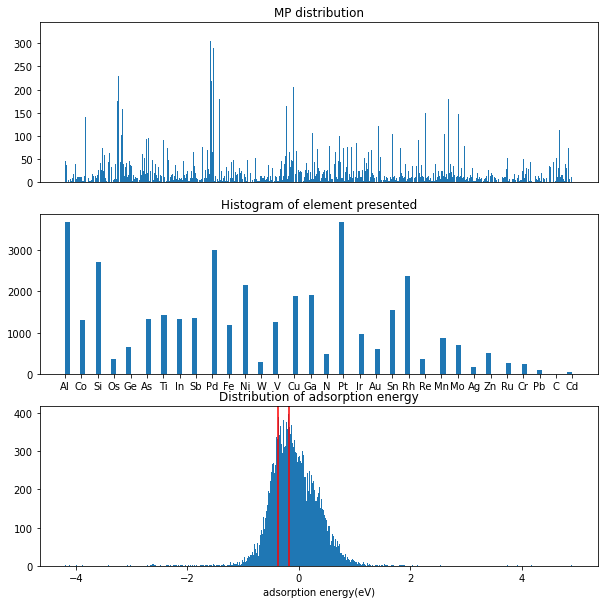

In [5]:
plt.figure(figsize = (10,10))

plt.subplot(3,1,1)
plt.title('MP distribution')
plt.hist(cdf.mpid.explode().to_list(),bins=746)
plt.xticks([])

plt.subplot(3,1,2)
plt.title('Histogram of element presented')
plt.hist(cdf.chemsys.explode().to_list(),bins=100)


plt.subplot(3,1,3)
plt.title('Distribution of adsorption energy')
plt.hist(cdf.energy.explode().to_list(),bins=500)
plt.axvline(x=-0.37, color='red')
plt.axvline(x=-0.17, color='red')
plt.xlabel('adsorption energy(eV)')

plt.show()

# Dimension Reduction & Visualization 

**Standardize the Data**

In [6]:
fea = cdf[list(cdf.keys())[4:]].to_numpy()
scaler = preprocessing.StandardScaler()
fea = scaler.fit_transform(fea)

In [7]:
n_components = fea.shape[-1]
print(n_components)

pca = PCA(n_components)
pca.fit(fea)
loading_vectors = pca.components_
explained_variance = pca.explained_variance_
pos = pca.transform(fea)

56


**Scree & Cumulative Scree plot**  
The standardized data are fed to PCA analysis for dimension reduction.
According to the Scree Plot, the max variance of the dataset is only ~ 0.12
Considering so, ~90% of the total variance is set as the cutoff point, which corresponds ~30 PCs
Therefore, only the first 30 PCs are considered in the later clustering. 

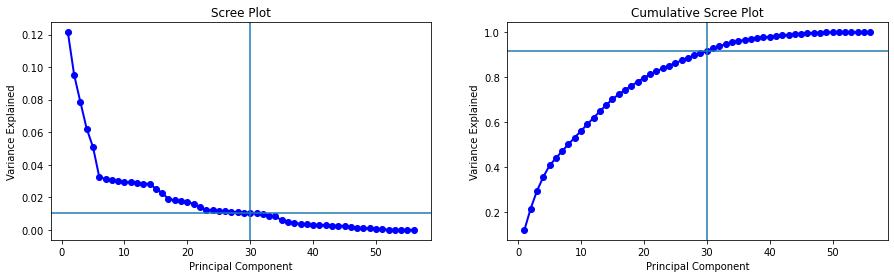

In [8]:
PC_values = np.arange(pca.n_components_) + 1
cutoff=30

plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.axvline(x=cutoff)
plt.axhline(y=pca.explained_variance_ratio_[cutoff-1])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

plt.subplot(1,2,2)
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Cumulative Scree Plot')
plt.axvline(x=cutoff)
plt.axhline(y=np.cumsum(pca.explained_variance_ratio_)[cutoff-1])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

For the PCA plot, the target "adsorption energy " is converted to the form of absolute difference from the ideal value for HER:-0.27eV

In [9]:
color = abs(cdf['energy'].to_numpy()-(-0.27))
print(color.min(),color.max())

1.4804999994011414e-05 5.171974605000004


**PCA plot**  
The fitted data are displayed in the scatter plot below, where x & y axis are the 1st and 2nd PCs respectively.
From the plot below, no clear trend of varation of the target value w.r.t PCA1 and PCA2 is observed. It could be associated with the fact that, as indicated by the Cumulative Scre Plot, only ~20% of the total variance are captured.
We can roughly tell there are brown clusters, which corresponds to data with non-ideal target values, and the data with close-to -idea target values tends to cluster more in the center of the scatter.

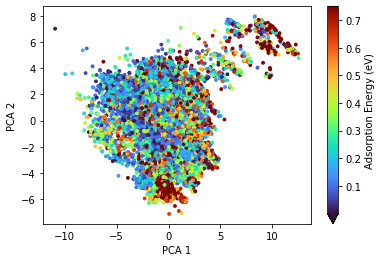

In [10]:
# vmax is capped at 0.75 to provide a more closer look at the distribution around the ideal value  
norm = colors.Normalize(vmin=color.min(), vmax=0.75)
plt.figure(4, figsize=(6,4))
plt.scatter(pos[:,0],pos[:,1],s=8,c = color,norm=norm, cmap='turbo')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label = 'Adsorption Energy (eV)',extend='min')

plt.show()

# KMeans Clustering

To determine the optimal number of clusters, the elbow method is first utilized, then the clustering for 3-7 clusters are visualized. Number of clusters 5 is chosen as the final. The stability of clustering result is confirmed through trying different random seed.

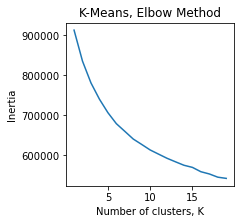

In [11]:
inertias = {}

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pos[:,:cutoff])
    inertias[k] = kmeans.inertia_ 
    
plt.figure(figsize=(3,3));
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");

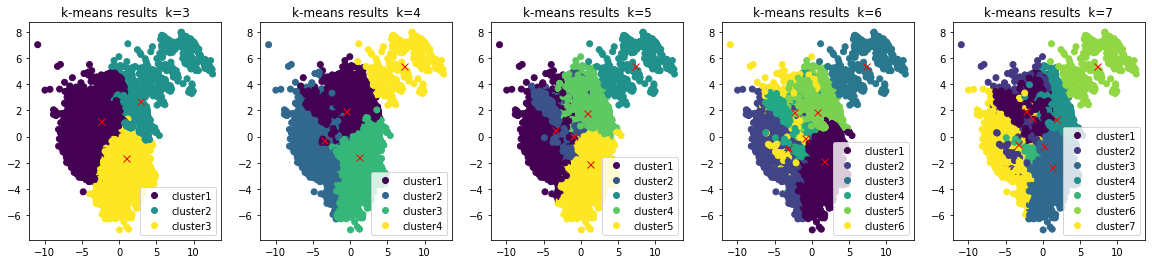

In [12]:
plt.figure(figsize = (20,4))
for k in range(3,8):
    kmeans = KMeans(n_clusters=k, random_state = 42).fit(pos[:,:cutoff])
    L = kmeans.labels_
    label = []
    for i in range(k):
        label.append('cluster'+str(i+1))
    cluster_centers = kmeans.cluster_centers_
    plt.subplot(1,5,k-2)
    scatter = plt.scatter(pos[:,0],pos[:,1],c = L)
    plt.plot(cluster_centers[:,0], cluster_centers[:,1], 'rx', markersize=7)
    plt.legend(scatter.legend_elements()[0],label,loc='lower right')
    plt.title('k-means results'+'  k='+str(k))
plt.show()

**Final KMeans Clustering**  
The element presented in each cluster are also plot, and is observed to have very different dominant element species.
Cluster 3, which is dominant by N-containing species, tends to have adsorption energy away from the ideal value  

Through comparing with the previous PCA plot the data with non-ideal target values are contained in cluster 3 & 5, and cluster 3 is relatively seperate from the other 4 clusters. 

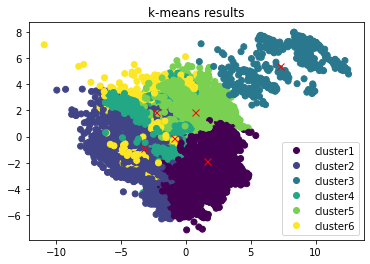

In [13]:
k = 6
plt.figure(figsize = (6,4))
kmeans = KMeans(n_clusters=k, random_state =42).fit(pos[:,:cutoff])
L = kmeans.labels_
label = []
for i in range(k):
    label.append('cluster'+str(i+1))
cluster_centers = kmeans.cluster_centers_
plt.subplot(1,1,1)
scatter = plt.scatter(pos[:,0],pos[:,1],c = L)
plt.plot(cluster_centers[:,0], cluster_centers[:,1], 'rx', markersize=7)
plt.legend(scatter.legend_elements()[0],label)
plt.title('k-means results')
plt.show()

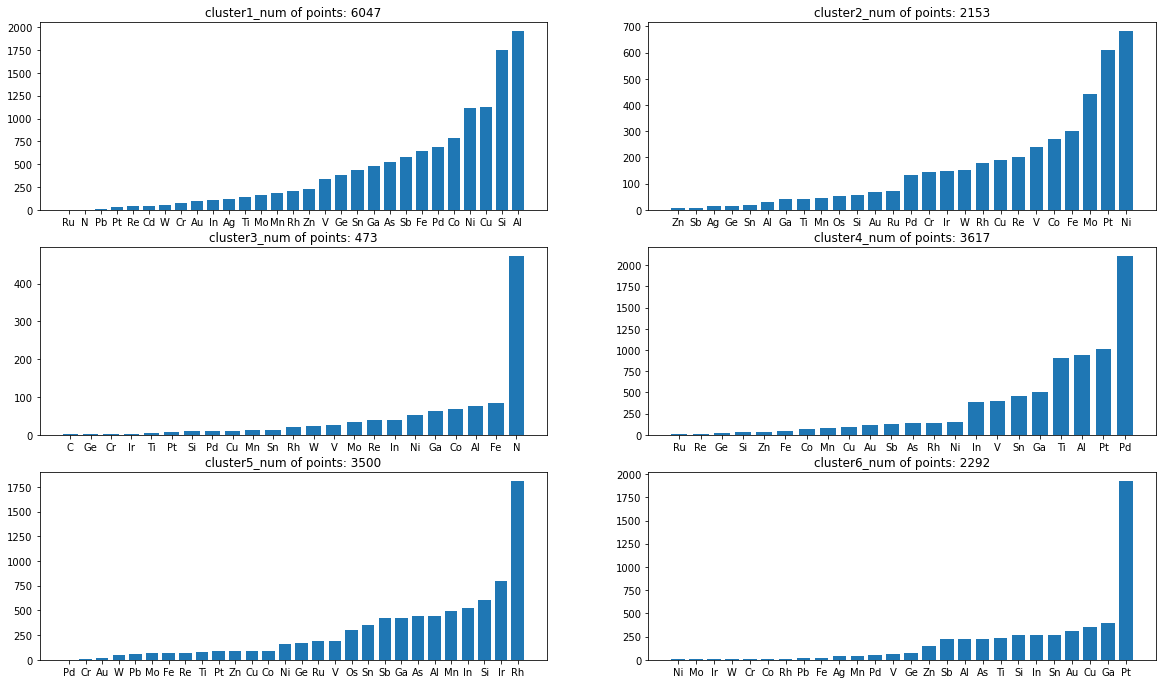

In [14]:
# https://stackoverflow.com/questions/15672178/plot-a-histogram-with-the-x-axis-values-based-on-the-height-of-the-column
# Visualize the element distribution  
cdf1=[pd.DataFrame(L),cdf]
cdf1=pd.concat(cdf1,axis=1)
cdf1
plt.figure(figsize = (20,20))
for i in range(k):
    plt.subplot(5,2,i+1)
    cluster = cdf1[cdf1[0]==i]
    data = cluster.chemsys.sum()
    correlation = [(i, data.count(i)) for i in set(data)]
    correlation.sort(key=lambda x: x[1])
    labels, values = zip(*correlation)
    indexes = np.arange(len(correlation))
    width = 0.75
    title = 'cluster'+str(i+1)+'_num of points: '+str(len(cluster))
    plt.title(label=title)
    plt.bar(indexes, values, width)
    plt.xticks(indexes, labels)
plt.show()

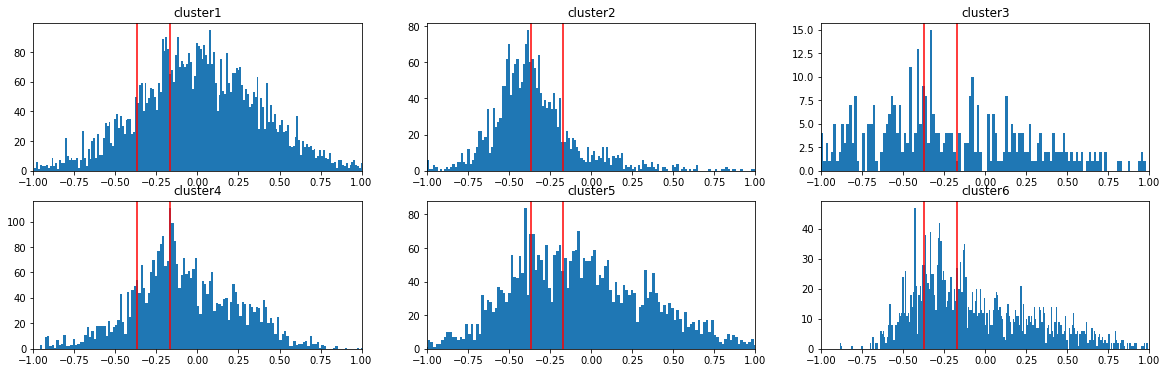

In [15]:
# Adsorption energy distribution for each cluster
plt.figure(figsize = (20,6))
for i in range(k):
    plt.subplot(2,3,i+1)
    cluster = cdf1[cdf1[0]==i]
    data = cluster.energy.explode()
    plt.hist(data,bins=500)
    plt.axvline(x=-0.37, color='red')
    plt.axvline(x=-0.17, color='red')
    title = 'cluster'+str(i+1) #+'_num of points: '+str(len(cluster))
    plt.xlim([-1,1]) 
    plt.title(label=title)
plt.show()